# Research Progress Meeting 2020-03-27

## Issue: determining spill volume

Last week's update has shown some inconsistencies between the incident spill volumes and incident cost. We did not find the relationship that we would expect there to be. In particular, there was a major spill in 2010 that incurred very high cost (Kalamazoo River oil spill); this spill did not stand out in terms of spill volume.

I compared this spill to the largest spill (by volume) in the dataset. The largest spill occured when oil spilled from a tank into a containment area - all oil could be recovered. Hence, I compared recovery volume - but the Kalaazoo River oil spill also shows a high recovery volume. My hypothesis is that when the oil was dug up (from the river bed and surrounding soil), the approximated volume was counted toward the recovered volume. Looking at the descriptions of the incidents might allow us to address this issue.

Also, I want to say that over the weekend, I was not very productive. And then after the Ivey building closed, that was another step back. My usual daily routine consists of leaving my home to go *anywhere* and then work - even if that is a cafe, or just a friends house. I bring this up just to say - *this meeting* really motivated me to focus on my research again, work concentrated on the problems in front of my eyes.

## Setup

In [1]:
library(tidyverse)
library(DataAnalysisTools)
library(oildata)

── Attaching packages ─────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
packageVersion("oildata")

[1] ‘1.1.2’

In [3]:
glimpse(pipelines)

Observations: 20,181
Variables: 29
$ year                         <dbl> 2008, 2008, 2008, 2008, 2008, 2008, 2008…
$ commodity                    <chr> "crude", "crude", "crude", "hvl", "hvl",…
$ ID                           <chr> "11733", "11733", "11733", "3156", "3156…
$ name                         <chr> "Loop", "Loop", "Loop", "Davis Gas Proce…
$ offshore_share               <dbl> 0.2008889, 0.2008889, 0.2008889, 0.00000…
$ on_offshore                  <chr> "total", "offshore", "onshore", "total",…
$ hca                          <dbl> 38.25, 3.00, 35.25, 1.00, 0.00, 1.00, 21…
$ miles                        <dbl> 112.50, 22.60, 89.90, 30.00, 0.00, 30.00…
$ volume_crude                 <dbl> 40852116635, NA, NA, 0, 0, 0, 0, 0, 0, 0…
$ volume_hvl                   <dbl> 0, NA, NA, 48, 0, 48, 0, 0, 0, 0, 0, 0, …
$ volume_rpp                   <dbl> 0, NA, NA, 0, 0, 0, 219591413, 0, 219591…
$ volume_other                 <dbl> 0, NA, NA, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ estimate_volume

In [4]:
glimpse(incidents)

Observations: 7,031
Variables: 27
$ DATAFILE_AS_OF      <dttm> 2020-01-30 04:13:09, 2020-01-30 04:13:09, 2020-0…
$ significant         <lgl> FALSE, TRUE, FALSE, FALSE, FALSE, TRUE, FALSE, FA…
$ serious             <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ incident_ID         <dbl> 20020037, 20020038, 20020039, 20020040, 20020041,…
$ ID                  <dbl> 19237, 25146, 12628, 2731, 4472, 2731, 4805, 1577…
$ name                <chr> "Te Products Pipeline", "Equistar Chemicals", "Mo…
$ year                <dbl> 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2…
$ lat                 <chr> "34 45' 18", "29 42' 31.86", "33.03.607", NA, NA,…
$ long                <chr> "92 11' 57", "95 15' 9.0", "097.35.244", " ", NA,…
$ cost                <dbl> 510, 98242, 47670, 3000, 2662, 76000, 1201, 2000,…
$ cost_1984           <dbl> 331.38683, 63835.50074, 30974.92234, 1949.33432, …
$ TOTAL_COST_CURRENT  <dbl> 707.53698, 136293.82002, 66133.89793, 4161.98225,…
$ commodity       

### Transformations

In [5]:
pipelines_year <- pipelines %>%
    filter(commodity %in% c("crude", "hvl", "rpp")) %>%
    group_by(year, on_offshore) %>%
    summarize(!!! oildata::pipelines_consolidation) %>%
    pivot_longer(cols = -c(year, on_offshore), names_to = "variable", values_to = "value")

glimpse(pipelines_year)

Observations: 1,035
Variables: 4
Groups: year [15]
$ year        <dbl> 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 200…
$ on_offshore <chr> "offshore", "offshore", "offshore", "offshore", "offshore…
$ variable    <chr> "hca", "miles", "volume_crude", "volume_hvl", "volume_rpp…
$ value       <dbl> 1.000900e+03, 5.085560e+03, NA, NA, NA, NA, 1.675448e+11,…


In [6]:
pipelines_y_c <- pipelines %>%
    filter(on_offshore == "onshore") %>%
    filter(commodity %in% c("crude", "hvl", "rpp")) %>%
    group_by(year, commodity) %>%
    summarize(!!! oildata::pipelines_consolidation) %>%
    mutate(cost_per_mile = incidents_cost/miles, 
           cost_per_volume = incidents_cost/estimate_volume_all, 
           volume_per_mile = incidents_volume/miles,
           volume_per_volume = incidents_volume/estimate_volume_all,
           inc_per_mile = incidents/miles, 
           inc_per_volume = incidents/estimate_volume_all,
           sign_inc_per_mile = significant_incidents/miles,
           sign_inc_per_volume = significant_incidents/estimate_volume_all) %>%
    pivot_longer(cols = -c(year, commodity), names_to = "variable", values_to = "value")

glimpse(pipelines_y_c)

Observations: 1,395
Variables: 4
Groups: year [15]
$ year      <dbl> 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004,…
$ commodity <chr> "crude", "crude", "crude", "crude", "crude", "crude", "crud…
$ variable  <chr> "hca", "miles", "volume_crude", "volume_hvl", "volume_rpp",…
$ value     <dbl> 1.754843e+04, 4.419932e+04, NA, NA, NA, NA, 1.803125e+12, 1…


## Recap

In [7]:
overview_spills <- pipelines_year %>%
    filter(on_offshore == "onshore") %>%
    filter(variable %in% c("incidents_cost", "incidents_volume", "significant_incidents", "estimate_volume_all")) %>%
    ggplot(aes(x = year, y = value)) +
        facet_wrap(on_offshore ~ variable, scales = "free", nrow = 1) +
        geom_line() +
        geom_smooth(method = "lm", se = FALSE) +
        scale_y_continuous(limits = c(0, NA)) +
        labs(x = NULL, y = NULL) 

options(repr.plot.width = 8, repr.plot.height = 2.3)

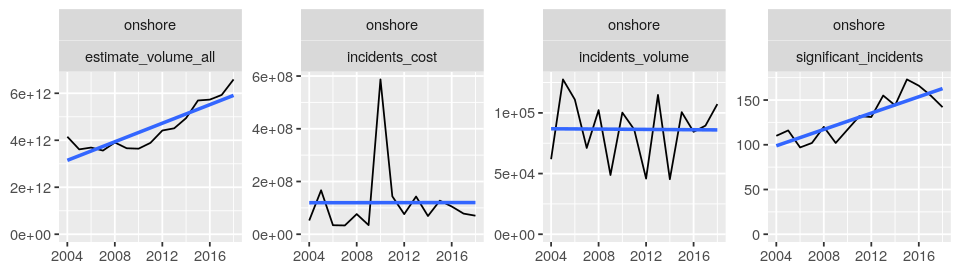

In [8]:
overview_spills

---
* More oil is being transported, while the volume of oil being spilled stays constant. 
* The incident in 2010 has not made a change to the spill volume, or maybe more oil is even being spilled again.

**Why do the incident cost spike in 2010, but the volume of spills does not?**

### Maybe it is overshadowed by HVL spills, which might be larger in volume?

In [9]:
overview_commodity <- pipelines_y_c %>%
    filter(variable %in% c("incidents_volume", "incidents_cost")) %>%
    ggplot(aes(x=year, y=value)) + 
        facet_wrap(variable ~ commodity, scales = "free") +
        geom_point() + geom_line() +
        geom_smooth(method = "lm", se = F) +
        scale_y_continuous(limits = c(0, NA)) +
        labs(x = NULL, y = NULL)

options(repr.plot.width=8, repr.plot.height=5)

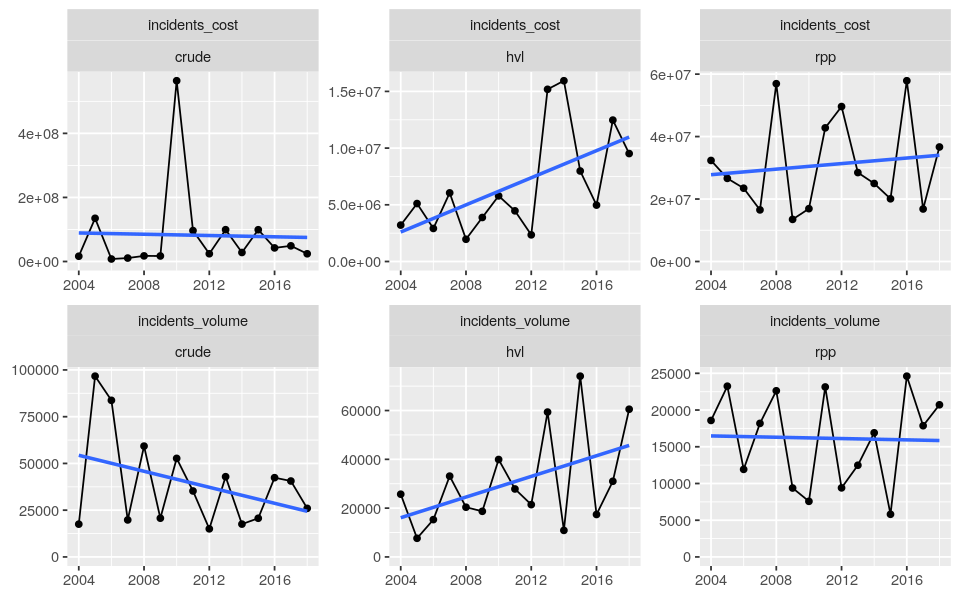

In [10]:
overview_commodity

**No, even in crude the year 2010 does not stand out in incidents volume for crude**

## Maybe if we look at the net loss...?

In [17]:
recovery <- pipelines_y_c %>%
    filter(variable %in% c("incidents_cost", "incidents_volume", "recovered", "net_loss_volume")) %>%
    ggplot(aes(x=year, y=value)) + 
        facet_wrap(commodity ~ variable, scales = "free") +
        geom_point() + geom_line() +
        geom_smooth(method = "lm", se = F) +
        scale_y_continuous(limits = c(0, NA)) +
        labs(x = NULL, y = NULL)

options(repr.plot.width=8, repr.plot.height=6)

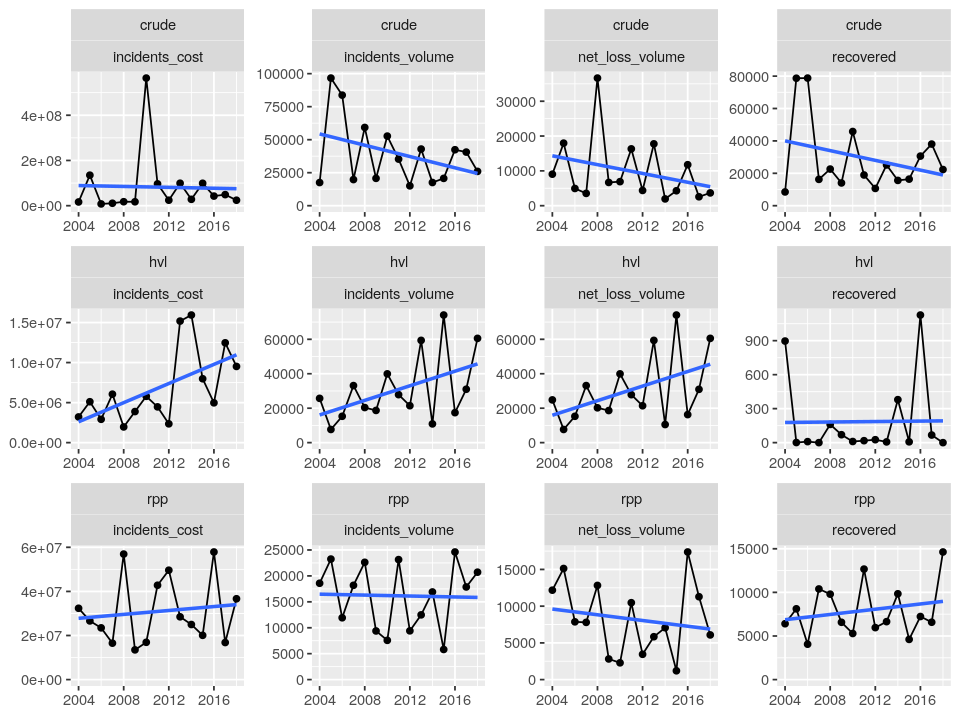

In [18]:
recovery

This does not provide a clear picture either. 

* We see that in 2010 a high amount of crude oil had to be recovered, which may ccount for the high incident cost in that year. 
* But even higher amounts were recovered in 2004 and 2005 without high incident cost.
* There is no clear relationship between cost, volume spilled and volume recovered for any commodity type.

## Looking at individual incidents to understand the discrepancy

In [19]:
glimpse(incidents)

Observations: 7,031
Variables: 27
$ DATAFILE_AS_OF      <dttm> 2020-01-30 04:13:09, 2020-01-30 04:13:09, 2020-0…
$ significant         <lgl> FALSE, TRUE, FALSE, FALSE, FALSE, TRUE, FALSE, FA…
$ serious             <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ incident_ID         <dbl> 20020037, 20020038, 20020039, 20020040, 20020041,…
$ ID                  <dbl> 19237, 25146, 12628, 2731, 4472, 2731, 4805, 1577…
$ name                <chr> "Te Products Pipeline", "Equistar Chemicals", "Mo…
$ year                <dbl> 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2…
$ lat                 <chr> "34 45' 18", "29 42' 31.86", "33.03.607", NA, NA,…
$ long                <chr> "92 11' 57", "95 15' 9.0", "097.35.244", " ", NA,…
$ cost                <dbl> 510, 98242, 47670, 3000, 2662, 76000, 1201, 2000,…
$ cost_1984           <dbl> 331.38683, 63835.50074, 30974.92234, 1949.33432, …
$ TOTAL_COST_CURRENT  <dbl> 707.53698, 136293.82002, 66133.89793, 4161.98225,…
$ commodity       

In [35]:
enbridge <- top_n(filter(incidents, commodity != "hvl"), 1, cost_1984)
select(enbridge, -narrative)

DATAFILE_AS_OF,significant,serious,incident_ID,ID,name,year,lat,long,cost,⋯,INJURE,cause,CAUSE_DETAILS,MAP_CAUSE,MAP_SUBCAUSE,SPILL_TYPE_CATEGORY,volume,recovered,date,net_loss
<dttm>,<lgl>,<lgl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<date>,<dbl>
2020-01-30 04:18:51,TRUE,FALSE,20100181,11169,"Enbridge Energy, Limited Partnership",2010,42.24329,-84.97251,840526118,⋯,NA,material,ENVIRONMENTAL CRACKING-RELATED,MATERIAL/WELD/EQUIP FAILURE,ENVIRONMENTAL CRACKING-RELATED,LARGE,20082,18245,2010-07-25,1837


In [36]:
enbridge$narrative %>%
    DataAnalysisTools::jupyter_styling(font_size = 14)

x
"On july 26, 2010, enbridge confirmed a mainline rupture on line 6b at mp608.2452. During the investigation it was determined that the rupture occurred simultaneously with a scheduled pipeline shutdown. As a result of the incident phmsa issued a corrective action order that ordered the pipeline to remain shut down until such time that the activities outlined in the cao were satisfied. Enbridge satisfied all conditions of the cao and received approval from phmsa to resume operations on september 27, 2010 at which time enbridge successfully restarted the line. Of further note, while the telephonic report to the nrc is stated as 13:33 on july 26, 2010, enbridge made a call to nrc and was on hold for a period of time. Enbridge then hung up the call and called again at which time it was on hold for a further period of time. The stated 13:33 reflects the time that enbridge was able to provide verbal notification of the incident. The release was initially estimated at 19,500 barrels of which an undetermined amount entered the talmadge creek and ultimately the kalamazoo river. The amount of estimated product released in or reaching water has not yet been confirmed and is based upon a calculation provided by an external consultant. The amount of oil that reached water is subject to further investigation. Enbridge is currently reviewing several methodologies to calculate this volume, and will communicate the methodology and subsequent volume to phmsa upon completion. The section that failed has been sent to a laboratory for a metallurgical analysis, under the direction of ntsb. Pending the results of metallurgical testing and failure investigations, enbridge is unable to provide complete and final data for this original report submission. Information contained in this report is to be considered estimated until supplemental and final reports are filed. Ntsb, phmsa and enbridge investigations into this accident have commenced. As this investigation is ongoing, the primary and secondary cause(s) have not been finalized. To date, enbridge has not found any potable water sources (public or private) with drinking water contamination that has been verifiably linked to the enbridge release. The assessment of all drinking water sources in the affected area is ongoing. Enbridge is in the process of sampling drinking water sources and is working directly with state and local public health officials in evaluating drinking water from potable wells to ensure public health. Enbridge estimated that it will incur aggregate charges between $300 million and $400 million. These charges include emergency response, environmental remediation and cleanup activities associated with the crude oil release, costs to repair the pipeline and related inspection costs, potential claims by third parties, and lost revenue. We continue to work to accurately project the total cost of the leak and its remediation, however we are unable to break it down into the specific detail requested in this form due to the complexity of the efforts. As further information becomes known, supplemental reports will be filed as required. See attached uploaded file for supplemental narrative as of december 20, 2010. See attached uploaded file for supplemental narrative as of february 22, 2011. See attached uploaded file for supplemental narrative as of march 6, 2012. See attached uploaded file for supplemental narrative as of june 28, 2013."


The incident report implies that recovery of oil in this case occured after the oil had already spilled into the river.
* Oil was recovered by digging up the soil.
* The volume recovered does not infer that the environmental damage was mitigated. It was recovered after the damage had already occured.

In [37]:
most_spilled <- top_n(filter(incidents, commodity != "hvl"), 1, volume)
select(most_spilled, -narrative)

DATAFILE_AS_OF,significant,serious,incident_ID,ID,name,year,lat,long,cost,⋯,INJURE,cause,CAUSE_DETAILS,MAP_CAUSE,MAP_SUBCAUSE,SPILL_TYPE_CATEGORY,volume,recovered,date,net_loss
<dttm>,<lgl>,<lgl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<date>,<dbl>
2020-01-30 04:13:09,TRUE,FALSE,20060071,31476,Semcrude,2006,58.68900,31.59494,705500,⋯,0,corrosion,"CORROSION, INTERNAL",CORROSION,INTERNAL,LARGE,49000,48900,2006-02-19,100


In [41]:
most_spilled$commodity

[1] "crude"

In [38]:
most_spilled$narrative

[1] "Leak occurred in bottom of crude oil storage tank.  All crude oil was contained inside tank dike and recovered within 72 hours."

In [43]:
most_net_loss <- top_n(filter(incidents, commodity != "hvl"), 1, net_loss)
select(most_net_loss, -narrative)

DATAFILE_AS_OF,significant,serious,incident_ID,ID,name,year,lat,long,cost,⋯,INJURE,cause,CAUSE_DETAILS,MAP_CAUSE,MAP_SUBCAUSE,SPILL_TYPE_CATEGORY,volume,recovered,date,net_loss
<dttm>,<lgl>,<lgl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<date>,<dbl>
2020-01-30 04:13:09,TRUE,FALSE,20080020,31684,Conocophillips,2008,N3303001,W102'57211,6681709,⋯,0,material,PIPE SEAM WELD,MATERIAL/WELD/EQUIP FAILURE,PIPE SEAM,LARGE,31322,331,2008-01-06,30991


In [45]:
most_net_loss$commodity

[1] "crude"

In [44]:
most_net_loss$narrative

[1] "Line wa from odessa, tx to borger, tx had a failure at mile post 83.4 between weems to slaughter. The failure occurred in the longtiudinal seam of a segment of pipe manufactured by a.o. Smith corperation using the electric flash-weld (efw) process. The failure originated at an area of seam misalignment. A notch-like geometry was formed between the pipe wall and the untrimmed seam flash on the id pipe surface. The stress concentration at the tip of the notch allowed for the initiation of an id-surface breaking crack. Pipe segment has been sent in to be analyzed. A ut crack tool inspection has been completed for the entire line.  Updated this report to reflect total cost for clean up and disposal as of march 12, 2009. This report will remain open until all remediation cost have been accounted for. The remediation program is scheduled for 2 years. Updated cost for remedation and amount of soil that has been treated to date. Quartley groundwater monitoring since release indicates no impact to ground water. After consulting with the sw region office cppl will close out this report no additional product amounts will be recovered from site."